In [149]:
import os
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import itertools # This allows us to mix and match
import random

from tensorflow.keras.preprocessing import image
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D, Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K

### Exploring our dataset

In [16]:
categories = os.listdir("lfw")

In [6]:
counts = {}
for category in categories:
    counts[category] = len(os.listdir(os.path.join("lfw",category)))

In [28]:
sorted(counts.items(), key=lambda x:x[1],reverse=True)

[('George_W_Bush', 530),
 ('Colin_Powell', 236),
 ('Tony_Blair', 144),
 ('Donald_Rumsfeld', 121),
 ('Gerhard_Schroeder', 109),
 ('Ariel_Sharon', 77),
 ('Hugo_Chavez', 71),
 ('Junichiro_Koizumi', 60),
 ('Jean_Chretien', 55),
 ('John_Ashcroft', 53),
 ('Jacques_Chirac', 52),
 ('Serena_Williams', 52),
 ('Vladimir_Putin', 49),
 ('Luiz_Inacio_Lula_da_Silva', 48),
 ('Gloria_Macapagal_Arroyo', 44),
 ('Arnold_Schwarzenegger', 42),
 ('Jennifer_Capriati', 42),
 ('Laura_Bush', 41),
 ('Lleyton_Hewitt', 41),
 ('Alejandro_Toledo', 39),
 ('Hans_Blix', 39),
 ('Nestor_Kirchner', 37),
 ('Andre_Agassi', 36),
 ('Alvaro_Uribe', 35),
 ('Megawati_Sukarnoputri', 33),
 ('Silvio_Berlusconi', 33),
 ('Tom_Ridge', 33),
 ('Kofi_Annan', 32),
 ('Roh_Moo-hyun', 32),
 ('Vicente_Fox', 32),
 ('David_Beckham', 31),
 ('John_Negroponte', 31),
 ('Guillermo_Coria', 30),
 ('Recep_Tayyip_Erdogan', 30),
 ('Bill_Clinton', 29),
 ('Mahmoud_Abbas', 29),
 ('Jack_Straw', 28),
 ('Juan_Carlos_Ferrero', 28),
 ('Ricardo_Lagos', 27),
 ('Gra

### Making Anchor, Positive and Negative dataset

In [27]:
# Getting all the images in a single folder/category

def get_image_paths(folder):
    return [os.path.join(folder,img) for img in os.listdir(folder)]

In [78]:
def create_triplets(dataset_path = "lfw_extracted"):
    categories = os.listdir(dataset_path)
    triplets = [] # This will contain the image paths for our training set

    for category in categories:
        folder_path = os.path.join(dataset_path,category)
        images = get_image_paths(folder_path)

        # Getting paths in other category for pairing

        other_category = [os.path.join(dataset_path, other_category)for other_category in categories if other_category != category]   
        other_images = [get_image_paths(category) for category in other_category]
        other_images = list(itertools.chain.from_iterable(other_images))

        # Creating unique positive pairs
        positive_pairs = list(itertools.combinations(images,2))


        for pair in positive_pairs:
            anchor, positive = pair
            negative = random.choice(other_images)
            triplets.append((anchor,positive,negative))
    
    return triplets

    

In [79]:
triplets = create_triplets()

In [80]:
# Creating preprocessing function

def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224,224)) # Target size matches the input size of the mobielnet
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis = 0)
    return tf.keras.applications.mobilenet.preprocess_input(img_array)

In [81]:
anchors, positives, negatives = [], [], []
for anchor_path, positive_path, negative_path in triplets:
    anchors.append(preprocess_image(anchor_path))
    positives.append(preprocess_image(positive_path))
    negatives.append(preprocess_image(negative_path))

# Convert to numpy arrays
anchors = np.vstack(anchors)
positives = np.vstack(positives)
negatives = np.vstack(negatives)

### Creating the model

In [82]:
from tensorflow.keras.applications import MobileNet

# Load pre-trained MobileNet without the top classification layer, freezing the weight
base_model = MobileNet(weights='imagenet', include_top=False)
base_model.trainable = False

# Add global average pooling layer
x = GlobalAveragePooling2D()(base_model.output)

# Create the feature extraction model
feature_extraction_model = Model(inputs=base_model.input, outputs=x)

In [88]:
# Define three inputs for anchor, positive, and negative images
input_anchor = Input(shape=(224, 224, 3))
input_positive = Input(shape=(224, 224, 3))
input_negative = Input(shape=(224, 224, 3))

# Reuse the same instance of the model for all three inputs
processed_anchor = feature_extraction_model(input_anchor)
processed_positive = feature_extraction_model(input_positive)
processed_negative = feature_extraction_model(input_negative)

# Triplet Loss Function
def triplet_loss(margin=1.0):
    def loss(y_true, y_pred):
        anchor, positive, negative = y_pred[:, 0:1024], y_pred[:, 1024:2048], y_pred[:, 2048:]
        pos_dist = K.sum(K.square(anchor - positive), axis=1)
        neg_dist = K.sum(K.square(anchor - negative), axis=1)
        basic_loss = pos_dist - neg_dist + margin
        loss = K.maximum(basic_loss, 0.0)
        return loss
    return loss

# Merge the outputs using a custom layer
merged_output = Lambda(lambda x: K.concatenate([x[0], x[1], x[2]], axis=1))([processed_anchor, processed_positive, processed_negative])

# Define the model
triplet_model = Model(inputs=[input_anchor, input_positive, input_negative], outputs=merged_output)

# Compile the model
triplet_model.compile(optimizer='rmsprop', loss=triplet_loss())

#Creating dummy label for model.fit
labels = np.zeros((anchors.shape[0], 1))

# Train the model with triplets
triplet_model.fit([anchors, positives, negatives], labels, epochs=10, batch_size=32)


Epoch 1/10
61/61 [==============================] - 5s 37ms/step - loss: 10.2137
Epoch 2/10
61/61 [==============================] - 2s 36ms/step - loss: 10.2137
Epoch 3/10
61/61 [==============================] - 2s 36ms/step - loss: 10.2137
Epoch 4/10
61/61 [==============================] - 2s 36ms/step - loss: 10.2137
Epoch 5/10
61/61 [==============================] - 2s 36ms/step - loss: 10.2137
Epoch 6/10
61/61 [==============================] - 2s 36ms/step - loss: 10.2137
Epoch 7/10
61/61 [==============================] - 2s 36ms/step - loss: 10.2137
Epoch 8/10
61/61 [==============================] - 2s 36ms/step - loss: 10.2137
Epoch 9/10
61/61 [==============================] - 2s 37ms/step - loss: 10.2135
Epoch 10/10
61/61 [==============================] - 2s 35ms/step - loss: 10.2137


In [89]:
def extract_features(model, img_path):
    img = preprocess_image(img_path)  # Use the same preprocess function as during training
    features = model.predict(img)
    return features.flatten()  # Reshape to 1D array

# Test images
test_image_path1 = 'lfw_extracted\Angela_Merkel\Angela_Merkel_0001.jpg'
test_image_path2 = 'lfw_extracted\Renee_Zellweger\Renee_Zellweger_0001.jpg'

# Extracting features
test_feature1 = extract_features(feature_extraction_model, test_image_path1)
test_feature2 = extract_features(feature_extraction_model, test_image_path2)

# Calculate Euclidean distance
from scipy.spatial.distance import euclidean
distance = euclidean(test_feature1, test_feature2)
print(distance)
# Define a threshold
threshold = 20 # Define based on your validation/testing

# Determine similarity
if distance < threshold:
    print("Images are similar.")
else:
    print("Images are not similar.")

1/1 [==============================] - 0s 16ms/step
18.429946899414062
Images are similar.


#### Trying with MobileNetV2

In [90]:
from tensorflow.keras.applications import MobileNetV2

# Load pre-trained MobileNet without the top classification layer, freezing the weights
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

# Add global average pooling layer
x = GlobalAveragePooling2D()(base_model.output)

# Create the feature extraction model
feature_extraction_model_v2 = Model(inputs=base_model.input, outputs=x)

In [101]:
# Define three inputs for anchor, positive, and negative images
input_anchor = Input(shape=(224, 224, 3))
input_positive = Input(shape=(224, 224, 3))
input_negative = Input(shape=(224, 224, 3))

# Reuse the same instance of the model for all three inputs
processed_anchor_v2 = feature_extraction_model_v2(input_anchor)
processed_positive_v2 = feature_extraction_model_v2(input_positive)
processed_negative_v2 = feature_extraction_model_v2(input_negative)

# Triplet Loss Function
def triplet_loss(margin=1.0):
    def loss(y_true, y_pred):
        anchor, positive, negative = y_pred[:, 0:1280], y_pred[:, 1280:2560], y_pred[:, 2560:]
        pos_dist = K.sum(K.square(anchor - positive), axis=1)
        neg_dist = K.sum(K.square(anchor - negative), axis=1)
        basic_loss = pos_dist - neg_dist + margin
        loss = K.maximum(basic_loss, 0.0)
        return loss
    return loss

# Merge the outputs using a custom layer
merged_output = Lambda(lambda x: K.concatenate([x[0], x[1], x[2]], axis=1))([processed_anchor_v2, processed_positive_v2, processed_negative_v2])

# Define the model
triplet_model = Model(inputs=[input_anchor, input_positive, input_negative], outputs=merged_output)

# Compile the model
triplet_model.compile(optimizer='rmsprop', loss=triplet_loss())

#Creating dummy label for model.fit
labels = np.zeros((anchors.shape[0], 1))

# Train the model with triplets
triplet_model.fit([anchors, positives, negatives], labels, epochs=25, batch_size=32)


Epoch 1/25
61/61 [==============================] - 7s 44ms/step - loss: 6.3006
Epoch 2/25
61/61 [==============================] - 3s 41ms/step - loss: 6.3009
Epoch 3/25
61/61 [==============================] - 3s 42ms/step - loss: 6.3008
Epoch 4/25
61/61 [==============================] - 3s 41ms/step - loss: 6.3007
Epoch 5/25
61/61 [==============================] - 3s 41ms/step - loss: 6.3007
Epoch 6/25
61/61 [==============================] - 3s 41ms/step - loss: 6.3007
Epoch 7/25
61/61 [==============================] - 3s 42ms/step - loss: 6.3008
Epoch 8/25
61/61 [==============================] - 3s 42ms/step - loss: 6.3007
Epoch 9/25
61/61 [==============================] - 3s 42ms/step - loss: 6.3007
Epoch 10/25
61/61 [==============================] - 3s 41ms/step - loss: 6.3007
Epoch 11/25
61/61 [==============================] - 3s 41ms/step - loss: 6.3007
Epoch 12/25
61/61 [==============================] - 3s 42ms/step - loss: 6.3007
Epoch 13/25
61/61 [==================

In [99]:
# Test images
test_image_path1 = 'lfw_extracted\Angela_Merkel\Angela_Merkel_0001.jpg'
test_image_path2 = 'lfw_extracted\Renee_Zellweger\Renee_Zellweger_0001.jpg'

# Extracting features
test_feature1 = extract_features(feature_extraction_model_v2, test_image_path1)
test_feature2 = extract_features(feature_extraction_model_v2, test_image_path2)

# Calculate Euclidean distance
from scipy.spatial.distance import euclidean
distance = euclidean(test_feature1, test_feature2)
print(distance)
# Define a threshold
threshold = 20 # Define based on your validation/testing

# Determine similarity
if distance < threshold:
    print("Images are similar.")
else:
    print("Images are not similar.")

1/1 [==============================] - 0s 16ms/step
21.423992156982422
Images are not similar.


#### Trying EfficientNet B0 model out

In [102]:
from tensorflow.keras.applications import EfficientNetB0

# Load pre-trained EfficientNetB0 without the top classification layer, freezing the weights
base_model = EfficientNetB0(weights='imagenet', include_top=False)
base_model.trainable = False

# Add global average pooling layer
x = GlobalAveragePooling2D()(base_model.output)

# Create the feature extraction model
feature_extraction_model_v3 = Model(inputs=base_model.input, outputs=x)


In [122]:
# Define three inputs for anchor, positive, and negative images
input_anchor = Input(shape=(224, 224, 3))
input_positive = Input(shape=(224, 224, 3))
input_negative = Input(shape=(224, 224, 3))

# Reuse the same instance of the model for all three inputs
processed_anchor_v3 = feature_extraction_model_v3(input_anchor)
processed_positive_v3 = feature_extraction_model_v3(input_positive)
processed_negative_v3 = feature_extraction_model_v3(input_negative)

# Triplet Loss Function
def triplet_loss(margin=1.0):
    def loss(y_true, y_pred):
        anchor, positive, negative = y_pred[:, 0:1280], y_pred[:, 1280:2560], y_pred[:, 2560:]
        pos_dist = K.sum(K.square(anchor - positive), axis=1)
        neg_dist = K.sum(K.square(anchor - negative), axis=1)
        basic_loss = pos_dist - neg_dist + margin
        loss = K.maximum(basic_loss, 0.0)
        return loss
    return loss

# Merge the outputs using a custom layer
merged_output = Lambda(lambda x: K.concatenate([x[0], x[1], x[2]], axis=1))([processed_anchor_v3, processed_positive_v3, processed_negative_v3])

# Define the model
triplet_model = Model(inputs=[input_anchor, input_positive, input_negative], outputs=merged_output)

# Compile the model
triplet_model.compile(optimizer='rmsprop', loss=triplet_loss())

#Creating dummy label for model.fit
labels = np.zeros((anchors.shape[0], 1))

# Train the model with triplets
triplet_model.fit([anchors, positives, negatives], labels, epochs=25, batch_size=32)

Epoch 1/25
61/61 [==============================] - 14s 63ms/step - loss: 1.4573
Epoch 2/25
61/61 [==============================] - 4s 63ms/step - loss: 1.3839
Epoch 3/25
61/61 [==============================] - 4s 65ms/step - loss: 1.4569
Epoch 4/25
61/61 [==============================] - 4s 65ms/step - loss: 1.5237
Epoch 5/25
61/61 [==============================] - 4s 65ms/step - loss: 1.5275
Epoch 6/25
61/61 [==============================] - 4s 65ms/step - loss: 1.5051
Epoch 7/25
61/61 [==============================] - 4s 64ms/step - loss: 1.4481
Epoch 8/25
61/61 [==============================] - 4s 63ms/step - loss: 1.4536
Epoch 9/25
61/61 [==============================] - 4s 63ms/step - loss: 1.3742
Epoch 10/25
61/61 [==============================] - 4s 63ms/step - loss: 1.4619
Epoch 11/25
61/61 [==============================] - 4s 64ms/step - loss: 1.4396
Epoch 12/25
61/61 [==============================] - 4s 64ms/step - loss: 1.4723
Epoch 13/25
61/61 [=================

In [111]:
# Test images
test_image_path1 = 'lfw_extracted\Angela_Merkel\Angela_Merkel_0001.jpg'
test_image_path2 = 'lfw_extracted\Junichiro_Koizumi\Junichiro_Koizumi_0040.jpg'

# Extracting features
test_feature1 = extract_features(feature_extraction_model_v3, test_image_path1)
test_feature2 = extract_features(feature_extraction_model_v3, test_image_path2)

# Calculate Euclidean distance
from scipy.spatial.distance import euclidean
distance = euclidean(test_feature1, test_feature2)
print(distance)
# Define a threshold
threshold = 20 # Define based on your validation/testing

# Determine similarity
if distance < threshold:
    print("Images are similar.")
else:
    print("Images are not similar.")

1/1 [==============================] - 0s 18ms/step
0.10288213938474655
Images are similar.


#### Trying wiht MobileNetV2 but with more dense layers on the top

In [137]:
from tensorflow.keras.applications import MobileNetV2

# Load pre-trained MobileNetV2 without the top classification layer, freezing the weights
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

# Flatten the output of the base model
flattened_output = Flatten()(base_model.output)

# Add three dense layers with 512 units each
dense_layer_1 = Dense(256, activation='relu')(flattened_output)
dense_layer_2 = Dense(256, activation='relu')(dense_layer_1)
dense_layer_3 = Dense(256, activation='relu')(dense_layer_2)

# Create the feature extraction model
feature_extraction_model_v4 = Model(inputs=base_model.input, outputs=dense_layer_3)


In [138]:
# Define three inputs for anchor, positive, and negative images
input_anchor = Input(shape=(224, 224, 3))
input_positive = Input(shape=(224, 224, 3))
input_negative = Input(shape=(224, 224, 3))

# Reuse the same instance of the model for all three inputs
processed_anchor_v4 = feature_extraction_model_v4(input_anchor)
processed_positive_v4 = feature_extraction_model_v4(input_positive)
processed_negative_v4 = feature_extraction_model_v4(input_negative)

# Triplet Loss Function
def triplet_loss(margin=1.0):
    def loss(y_true, y_pred):
        # Corrected slicing for 256-unit output
        num_features = 256  # Output size of the last dense layer
        anchor, positive, negative = y_pred[:, :num_features], y_pred[:, num_features:2*num_features], y_pred[:, 2*num_features:3*num_features]
        pos_dist = K.sum(K.square(anchor - positive), axis=1)
        neg_dist = K.sum(K.square(anchor - negative), axis=1)
        basic_loss = pos_dist - neg_dist + margin
        loss = K.maximum(basic_loss, 0.0)
        return loss
    return loss

# Merge the outputs using a custom layer
merged_output = Lambda(lambda x: K.concatenate([x[0], x[1], x[2]], axis=1))([processed_anchor_v4, processed_positive_v4, processed_negative_v4])

# Define the model
triplet_model = Model(inputs=[input_anchor, input_positive, input_negative], outputs=merged_output)

# Compile the model
triplet_model.compile(optimizer='rmsprop', loss=triplet_loss())

#Creating dummy label for model.fit
labels = np.zeros((anchors.shape[0], 1))

# Train the model with triplets
with tf.device('/GPU:0'):
    triplet_model.fit([anchors, positives, negatives], labels, epochs=25, batch_size=16)

Epoch 1/25
121/121 [==============================] - 8s 28ms/step - loss: 429.4547
Epoch 2/25
121/121 [==============================] - 3s 28ms/step - loss: 51.3023
Epoch 3/25
121/121 [==============================] - 3s 28ms/step - loss: 0.0000e+00
Epoch 4/25
121/121 [==============================] - 3s 28ms/step - loss: 0.0000e+00
Epoch 5/25
121/121 [==============================] - 3s 28ms/step - loss: 0.0000e+00
Epoch 6/25
121/121 [==============================] - 3s 28ms/step - loss: 0.0000e+00
Epoch 7/25
121/121 [==============================] - 3s 29ms/step - loss: 0.0000e+00
Epoch 8/25
121/121 [==============================] - 4s 29ms/step - loss: 0.0000e+00
Epoch 9/25
121/121 [==============================] - 3s 29ms/step - loss: 0.0000e+00
Epoch 10/25
121/121 [==============================] - 3s 28ms/step - loss: 0.0000e+00
Epoch 11/25
121/121 [==============================] - 3s 28ms/step - loss: 0.0000e+00
Epoch 12/25
121/121 [==============================] - 3s

In [117]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

1/1 [==============================] - 0s 18ms/step
Euclidean Distance: 399.3002624511719


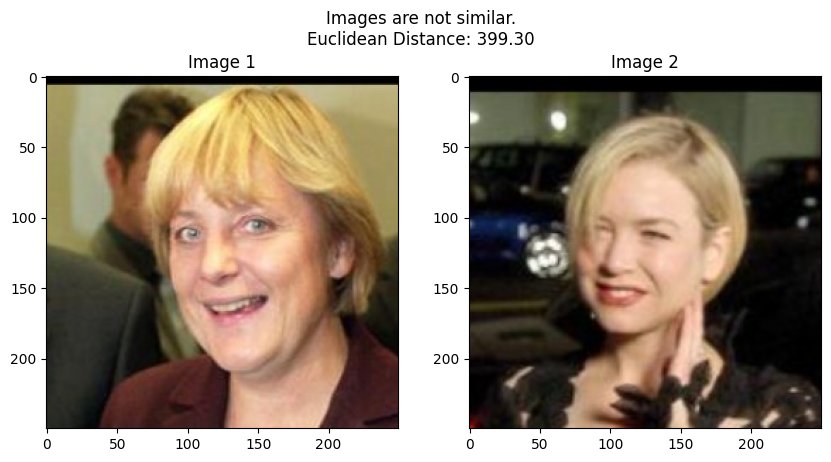

In [146]:
from scipy.spatial.distance import euclidean
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Test images
test_image_path1 = 'lfw_extracted\Angela_Merkel\Angela_Merkel_0001.jpg'
test_image_path2 = 'lfw_extracted\Renee_Zellweger\Renee_Zellweger_0001.jpg'

# Extracting features
test_feature1 = extract_features(feature_extraction_model_v4, test_image_path1)
test_feature2 = extract_features(feature_extraction_model_v4, test_image_path2)

# Calculate Euclidean distance
distance = euclidean(test_feature1, test_feature2)
print("Euclidean Distance:", distance)

# Define a threshold
threshold = 20 # Define based on your validation/testing

# Load and plot the images
img1 = mpimg.imread(test_image_path1)
img2 = mpimg.imread(test_image_path2)

# Plot the images side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(img1)
axes[0].set_title('Image 1')
axes[1].imshow(img2)
axes[1].set_title('Image 2')

# Determine similarity and display the result
if distance < threshold:
    result = "Images are similar."
else:
    result = "Images are not similar."

# Add the distance as a text annotation
fig.suptitle(result + f'\nEuclidean Distance: {distance:.2f}', fontsize=12)
plt.show()


1/1 [==============================] - 0s 19ms/step
Cosine Similarity Score: 0.6152924


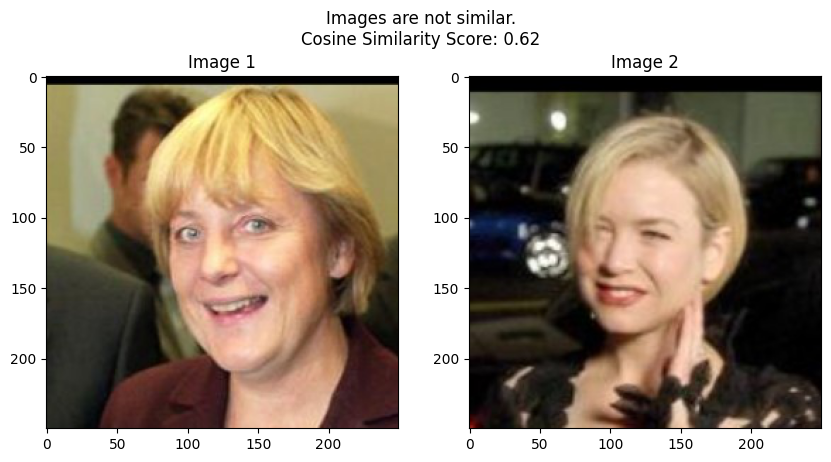

In [157]:
# Test images
test_image_path1 = 'lfw_extracted\Angela_Merkel\Angela_Merkel_0001.jpg'
test_image_path2 = 'lfw_extracted\Renee_Zellweger\Renee_Zellweger_0001.jpg'

# Extracting features
test_feature1 = extract_features(feature_extraction_model_v2, test_image_path1)
test_feature2 = extract_features(feature_extraction_model_v2, test_image_path2)

# Calculate cosine similarity
similarity_score = cosine_similarity([test_feature1], [test_feature2])[0][0]
print("Cosine Similarity Score:", similarity_score)

# Define a similarity threshold (adjust as needed)
threshold = 0.8  # You can set this threshold based on your validation/testing

# Load and plot the images
img1 = mpimg.imread(test_image_path1)
img2 = mpimg.imread(test_image_path2)

# Plot the images side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(img1)
axes[0].set_title('Image 1')
axes[1].imshow(img2)
axes[1].set_title('Image 2')

# Determine similarity and display the result
if similarity_score >= threshold:
    result = "Images are similar."
else:
    result = "Images are not similar."

# Add the similarity score as a text annotation
fig.suptitle(result + f'\nCosine Similarity Score: {similarity_score:.2f}', fontsize=12)
plt.show()
